In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from tabulate import tabulate
from tensorflow import keras
from kerastuner import Hyperband, Objective
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam

C:\Users\Alon\AppData\Local\Temp\ipykernel_38552\3505400514.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import Hyperband, Objective


In [2]:
# Import the data
f = 'weatherHistory.csv'

weather = pd.read_csv(f)
weather.head(10)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


In [3]:
weather.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [4]:
weather['Formatted Date'] = pd.to_datetime(weather['Formatted Date'], utc=True)

# Set the 'Formatted Date' column as index
weather.set_index('Formatted Date', inplace=True)
weather = weather.sort_index()

In [5]:
# Change index to a datetime64 type
weather.index = pd.to_datetime(weather.index)
print(weather.index.dtype)

datetime64[ns, UTC]


In [6]:
# Check for any missing values in the dataset
missing_values = weather.isnull().sum()
print(missing_values)
weather['Precip Type'].unique()



Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


array(['rain', 'snow', nan], dtype=object)

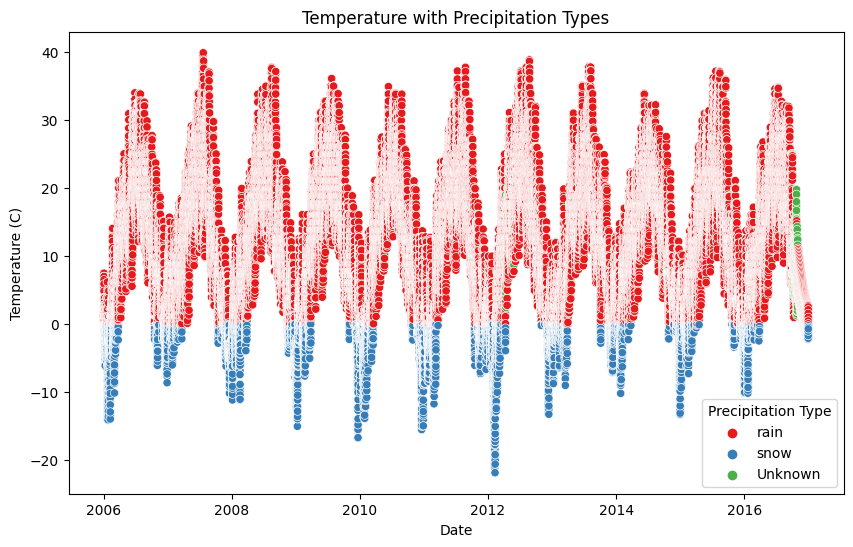

In [7]:
# Fill NaN values in 'Precip Type' column with the placeholder 'Unknown' to visualize
weather['Precip Type'].fillna('Unknown', inplace=True)

# Plot the feature to understand the spread of the values and the missing values using Seaborn's scatterplot
plt.figure(figsize=(10, 6))

sns.scatterplot(data=weather, x=weather.index, y='Temperature (C)', hue='Precip Type', palette='Set1')

plt.title('Temperature with Precipitation Types')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend(title='Precipitation Type')
plt.show()

<h3>Conclusions:</h3>
<p>The data of <i>'Precip Type'</i> seems insignificant for modelling. It is only an indicator of above/below zero temperature already captured by the Temperature column and does not give information about actual precipitaion in the area.
Therefore it will not be included in the model.

Along with it, <i>'Daily Summary'</i> is dropped due to redundancy, <i>'Loud Cover'</i> is dropped since it is a column of 0s and <i>'Apparent Temperature (C)'</i> is dropped since we are not allowed to use it for this project.</p>

In [8]:
# Drop columns
weather.drop(columns=['Apparent Temperature (C)', 'Precip Type', 'Loud Cover', 'Daily Summary'], inplace=True)

# Verify changes
weather.head()

,Summary,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,,
2005-12-31 23:00:00+00:00,Partly Cloudy,0.577778,0.89,17.1143,140.0,9.9820,1016.66
2006-01-01 00:00:00+00:00,Mostly Cloudy,1.161111,0.85,16.6152,139.0,9.9015,1016.15
2006-01-01 01:00:00+00:00,Mostly Cloudy,1.666667,0.82,20.2538,140.0,9.9015,1015.87
2006-01-01 02:00:00+00:00,Overcast,1.711111,0.82,14.4900,140.0,9.9015,1015.56
2006-01-01 03:00:00+00:00,Mostly Cloudy,1.183333,0.86,13.9426,134.0,9.9015,1014.98


In [9]:
# Replace the degrees with categorical values and create n-1 dummy variables to represent wind directions
# Keep the original data in a separate variable
wind_degrees = weather['Wind Bearing (degrees)']

# Define function to map wind bearings to categories
def map_wind_direction(degrees):
    directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    degree_ranges = [(348.75, 11.25), (11.25, 33.75), (33.75, 56.25), (56.25, 78.75),(78.75, 101.25), (101.25, 123.75),
                     (123.75, 146.25), (146.25, 168.75), (168.75, 191.25), (191.25, 213.75), (213.75, 236.25),
                     (236.25, 258.75), (258.75, 281.25), (281.25, 303.75), (303.75, 326.25), (326.25, 348.75)]
    for direction, (start, end) in zip(directions, degree_ranges):
        if start <= degrees < end:
            return direction
    return directions[0]  # Default to 'N' if not in any range

# Map wind direction
weather['Wind Direction'] = weather['Wind Bearing (degrees)'].apply(map_wind_direction)

# Perform one-hot encoding
weather = pd.get_dummies(weather, columns=['Wind Direction'], prefix='Wind', drop_first=True)

# Drop original 'Wind Bearing (degrees)' column
weather.drop(columns=['Wind Bearing (degrees)'], inplace=True)

# Create dummy variable for all different possible summaries in the 'Summary' column
# Keep the original data in a separate variable
weather_summary = weather['Summary']

# Perform one-hot encoding for 'Summary' column
weather = pd.get_dummies(weather, columns=['Summary'], prefix='Summary', drop_first=True)

# Create dummy variables for the months of the year and hour of the day from the index
# Extract month and hour from datetime index
weather['Month'] = weather.index.month
weather['Hour'] = weather.index.hour

# Perform one-hot encoding for 'Month' and 'Hour' columns
weather = pd.get_dummies(weather, columns=['Month'], prefix='Month', drop_first=True)
weather = pd.get_dummies(weather, columns=['Hour'], prefix='Hour', drop_first=True)


# Verify changes
print(weather.head())

                           Temperature (C)  Humidity  Wind Speed (km/h)  \
Formatted Date                                                            
2005-12-31 23:00:00+00:00         0.577778      0.89            17.1143   
2006-01-01 00:00:00+00:00         1.161111      0.85            16.6152   
2006-01-01 01:00:00+00:00         1.666667      0.82            20.2538   
2006-01-01 02:00:00+00:00         1.711111      0.82            14.4900   
2006-01-01 03:00:00+00:00         1.183333      0.86            13.9426   

                           Visibility (km)  Pressure (millibars)  Wind_ENE  \
Formatted Date                                                               
2005-12-31 23:00:00+00:00           9.9820               1016.66         0   
2006-01-01 00:00:00+00:00           9.9015               1016.15         0   
2006-01-01 01:00:00+00:00           9.9015               1015.87         0   
2006-01-01 02:00:00+00:00           9.9015               1015.56         0   
2006-0

### Model Dataset Construction

In [10]:
def create_dataset(X, y, window_size, test_size=0.2, val_size=0.2, shuffle=False):
    # Exclude dummy variables from scaling
    continuous_columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
    X_continuous = X[:, :len(continuous_columns)]
    
    # Scale continuous features
    scaler = StandardScaler()
    X_continuous_scaled = scaler.fit_transform(X_continuous.reshape(-1, len(continuous_columns))).reshape(X_continuous.shape)

    # Combine scaled continuous features with dummy variables
    X_scaled = np.concatenate((X_continuous_scaled, X[:, len(continuous_columns):]), axis=-1)

    # # Reshape data for LSTM input (samples, time steps, features)
    # X_scaled = X_scaled.reshape(X_scaled.shape[0], window_size, -1)
    
    # Create input-output pairs
    X_train_data, y_train_data = [], []
    for i in range(len(X_scaled) - window_size - 23):  # Rolling window range defined by X's end to avoid rolling over the data
        # Append the window size starting at each hour of X_train
        X_train_data.append(X_scaled[i:i+window_size])
        # Append the next 24 observations (1 day after last observation of X_train) to y_train_data
        y_train_data.append(y[i+window_size:i+window_size+24])
    
    X_train_data = np.array(X_train_data)
    y_train_data = np.array(y_train_data)

    # Split data into train, test and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=test_size, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=shuffle)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
# Define window size
window_size = 24 * 3  # 3 days (24 hours each)
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(weather.values, weather['Temperature (C)'].values, window_size, test_size=0.2, val_size=0.2, shuffle=False)

### Model

In [12]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [13]:
def build_lstm_model(hp):
  # Define search space for hyperparameters
  optimizer = hp.Choice('optimizer', ['rmsprop', 'adam', 'sgd', 'nadam'])
  loss = hp.Choice('loss', ['mse', 'mae'])
  lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
  dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
  learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

  # Build LSTM model with hyperparameters
  model = Sequential()
  model.add(LSTM(units=lstm_units, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(BatchNormalization())
  model.add(Dense(units=dense_units, activation="relu"))
  model.add(BatchNormalization())
  model.add(Dense(units=dense_units, activation="relu"))
  model.add(Dense(units=24))
  # Define optimizer with the chosen learning rate
  if optimizer == 'rmsprop':
      opt = RMSprop(learning_rate=learning_rate)
  elif optimizer == 'adam':
      opt = Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
      opt = SGD(learning_rate=learning_rate)
  else:
      opt = Nadam(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=loss)
  return model

In [14]:
# Defien project name
project_name = 'lstm_tuning_'+input("Please select the model number")

# Define tuner with Hyperband search algorithm
objective = Objective("val_loss", direction="min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

tuner = Hyperband(
    build_lstm_model,
    objective=objective,
    max_epochs=50,
    project_name=project_name,
    executions_per_trial=2,
    overwrite=True
)

# Fit the tuner
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[reduce_lr])

# Get the best model
best_model = tuner.get_best_models()[0]
best_model.save(f'{project_name}.keras')

Trial 90 Complete [02h 14m 12s]
val_loss: 1.7206256985664368

Best val_loss So Far: 1.6721491813659668
Total elapsed time: 1d 10h 53m 31s


In [196]:
best_model = load_model(f'{project_name}.keras')
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               107008    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 24)                1

In [197]:
# Get best hyperparamers
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
optimizer = best_hps.get('optimizer')
loss = best_hps.get('loss')
epochs = best_hps.get('tuner/epochs')
learning_rate = best_hps.get('learning_rate')

# Extract the values of the best hyperparameters
hyperparameter_values = [(key, value) for key, value in best_hps.values.items()]

# Print the tabulated hyperparameters
print(tabulate(hyperparameter_values[:-3], headers=["Hyperparameter", "Tuned Value"], tablefmt="rounded_grid"))

╭──────────────────┬───────────────╮
│ Hyperparameter   │ Tuned Value   │
├──────────────────┼───────────────┤
│ optimizer        │ adam          │
├──────────────────┼───────────────┤
│ loss             │ mae           │
├──────────────────┼───────────────┤
│ lstm_units       │ 128           │
├──────────────────┼───────────────┤
│ dense_units      │ 64            │
├──────────────────┼───────────────┤
│ learning_rate    │ 0.0001        │
├──────────────────┼───────────────┤
│ tuner/epochs     │ 50            │
╰──────────────────┴───────────────╯


In [198]:
# Define EarlyStopping callback 
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the best_model with the desired metrics
best_model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

# Train the best model with early stopping using validation data
history = best_model.fit(X_train, y_train, epochs=epochs,
              validation_data=(X_val, y_val), batch_size=38)

Epoch 1/50
1623/1623 [==============================] - 146s 79ms/step - loss: 1.8495 - rmse: 2.2000 - val_loss: 1.7455 - val_rmse: 2.0827
Epoch 2/50
1623/1623 [==============================] - 89s 55ms/step - loss: 1.7490 - rmse: 2.0925 - val_loss: 1.8373 - val_rmse: 2.1634
Epoch 3/50
1623/1623 [==============================] - 87s 53ms/step - loss: 1.6897 - rmse: 2.0282 - val_loss: 1.9575 - val_rmse: 2.3042
Epoch 4/50
1623/1623 [==============================] - 86s 53ms/step - loss: 1.6270 - rmse: 1.9595 - val_loss: 1.7206 - val_rmse: 2.0485
Epoch 5/50
1623/1623 [==============================] - 86s 53ms/step - loss: 1.5736 - rmse: 1.8993 - val_loss: 1.7632 - val_rmse: 2.1028
Epoch 6/50
1623/1623 [==============================] - 85s 52ms/step - loss: 1.4887 - rmse: 1.8036 - val_loss: 1.8304 - val_rmse: 2.1709
Epoch 7/50
1623/1623 [==============================] - 85s 52ms/step - loss: 1.4175 - rmse: 1.7239 - val_loss: 1.8434 - val_rmse: 2.1836
Epoch 8/50
1623/1623 [===========

In [199]:
# Extract one before the last 74 hours of X_test_scaled
X_test_last_74_hours = X_test[-1:, :]

# Make predictions based on the last 3-day window
predictions = best_model.predict(X_test_last_74_hours)

# Initialize a list to store rows of the table
table_data = []

# Get the date and time for the current prediction from the original DataFrame
date_time = weather.index[-24:].strftime('%Y-%m-%d %H:%M')

difference = []
# Append a row to the table_data list containing date-time, predicted values, and actual values
for j in range(24):
    difference.append(abs(y_test[-1][j] - predictions[0][j]))
    table_data.append([date_time[j], predictions[0][j], y_test[-1][j],difference[-1]])

# Define column headers
headers = ['Date-Time', 'Predicted', 'Actual', 'Difference']

# Print the table using tabulate
print(tabulate(table_data, headers=headers, tablefmt="rounded_grid"))



1/1 [==============================] - 2s 2s/step
╭──────────────────┬─────────────┬────────────┬──────────────╮
│ Date-Time        │   Predicted │     Actual │   Difference │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-30 23:00 │  -1.98102   │ -0.872222  │     1.10879  │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-31 00:00 │  -2.15013   │ -1.16111   │     0.989023 │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-31 01:00 │  -2.25931   │ -1.48889   │     0.770418 │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-31 02:00 │  -2.51516   │ -1.82222   │     0.692937 │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-31 03:00 │  -2.93939   │ -2.07778   │     0.861609 │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 2016-12-31 04:00 │  -3.31965   │ -2.17778   │     1.14187  │
├──────────────────┼─────────────┼────────────┼──────────────┤
│ 201

In [200]:
# Evaluate the model
test_loss, test_rmse = best_model.evaluate(X_test, y_test, verbose=1)
print(f"""Test loss: {test_loss:.2f}
Test rmse: {test_rmse:.2f}°C""")

603/603 [==============================] - 8s 13ms/step - loss: 2.0655 - rmse: 2.4164
Test loss: 2.07
Test rmse: 2.42°C


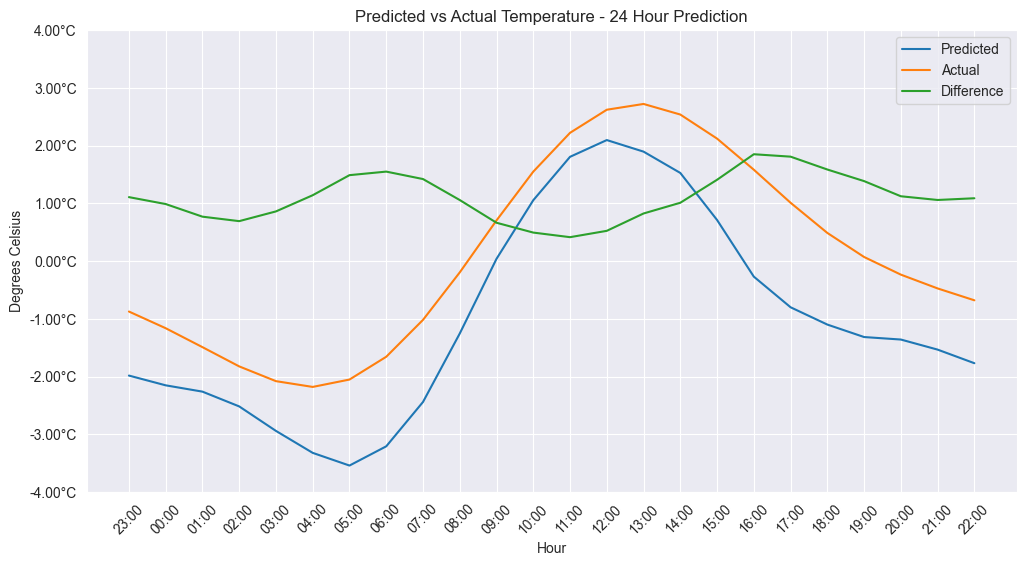

In [201]:
# Convert date_time to datetime objects
date_time = pd.to_datetime(date_time)
hour_minute = date_time.strftime('%H:%M')

# Plot predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(hour_minute, predictions[0], label='Predicted')
plt.plot(hour_minute, y_test[-1], label='Actual')
plt.plot(hour_minute, difference, label='Difference')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')
plt.title('Predicted vs Actual Temperature - 24 Hour Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
# Add degree Celsius symbol to y-axis ticks
plt.yticks(plt.gca().get_yticks(), [f'{x:.2f}°C' for x in plt.gca().get_yticks()])
plt.show()

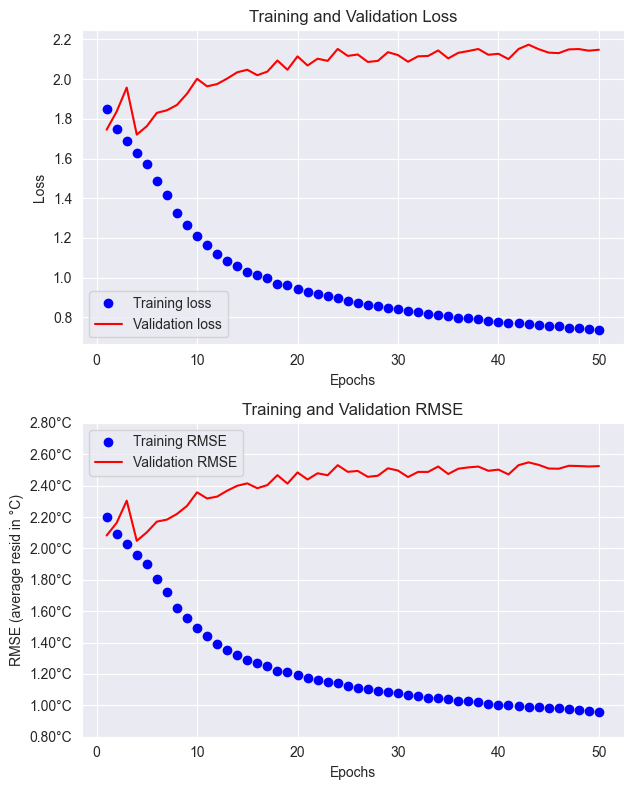

In [202]:
# Extract metrics from history
loss_metric = history.history['loss']
val_loss_metric = history.history['val_loss']
rmse_metric = history.history['rmse']
val_rmse_metric = history.history['val_rmse']

# Plot training and validation loss
epochs = range(1, len(loss_metric) + 1)
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_metric, 'bo', label='Training loss')
plt.plot(epochs, val_loss_metric, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(epochs, rmse_metric, 'bo', label='Training RMSE')
plt.plot(epochs, val_rmse_metric, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE (average resid in °C)')
plt.legend()

# Add degree Celsius symbol to y-axis ticks
plt.yticks(plt.gca().get_yticks(), [f'{x:.2f}°C' for x in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 26ms/step
+------------------+--------------+------------+--------------+
| Date-Time        |    Predicted |     Actual |   Difference |
+==================+==============+============+==============+
| 2016-12-24 23:00 | -1.48173     | -0.566667  |    0.915063  |
+------------------+--------------+------------+--------------+
| 2016-12-25 00:00 | -1.6358      | -0.855556  |    0.780248  |
+------------------+--------------+------------+--------------+
| 2016-12-25 01:00 | -1.68821     | -1.18333   |    0.504878  |
+------------------+--------------+------------+--------------+
| 2016-12-25 02:00 | -1.85309     | -1.51111   |    0.341982  |
+------------------+--------------+------------+--------------+
| 2016-12-25 03:00 | -2.21426     | -1.76667   |    0.447596  |
+------------------+--------------+------------+--------------+
| 2016-12-25 04:00 | -2.50578     | -1.85556   |    0.650229  |
+------------------+--------------+------------+----

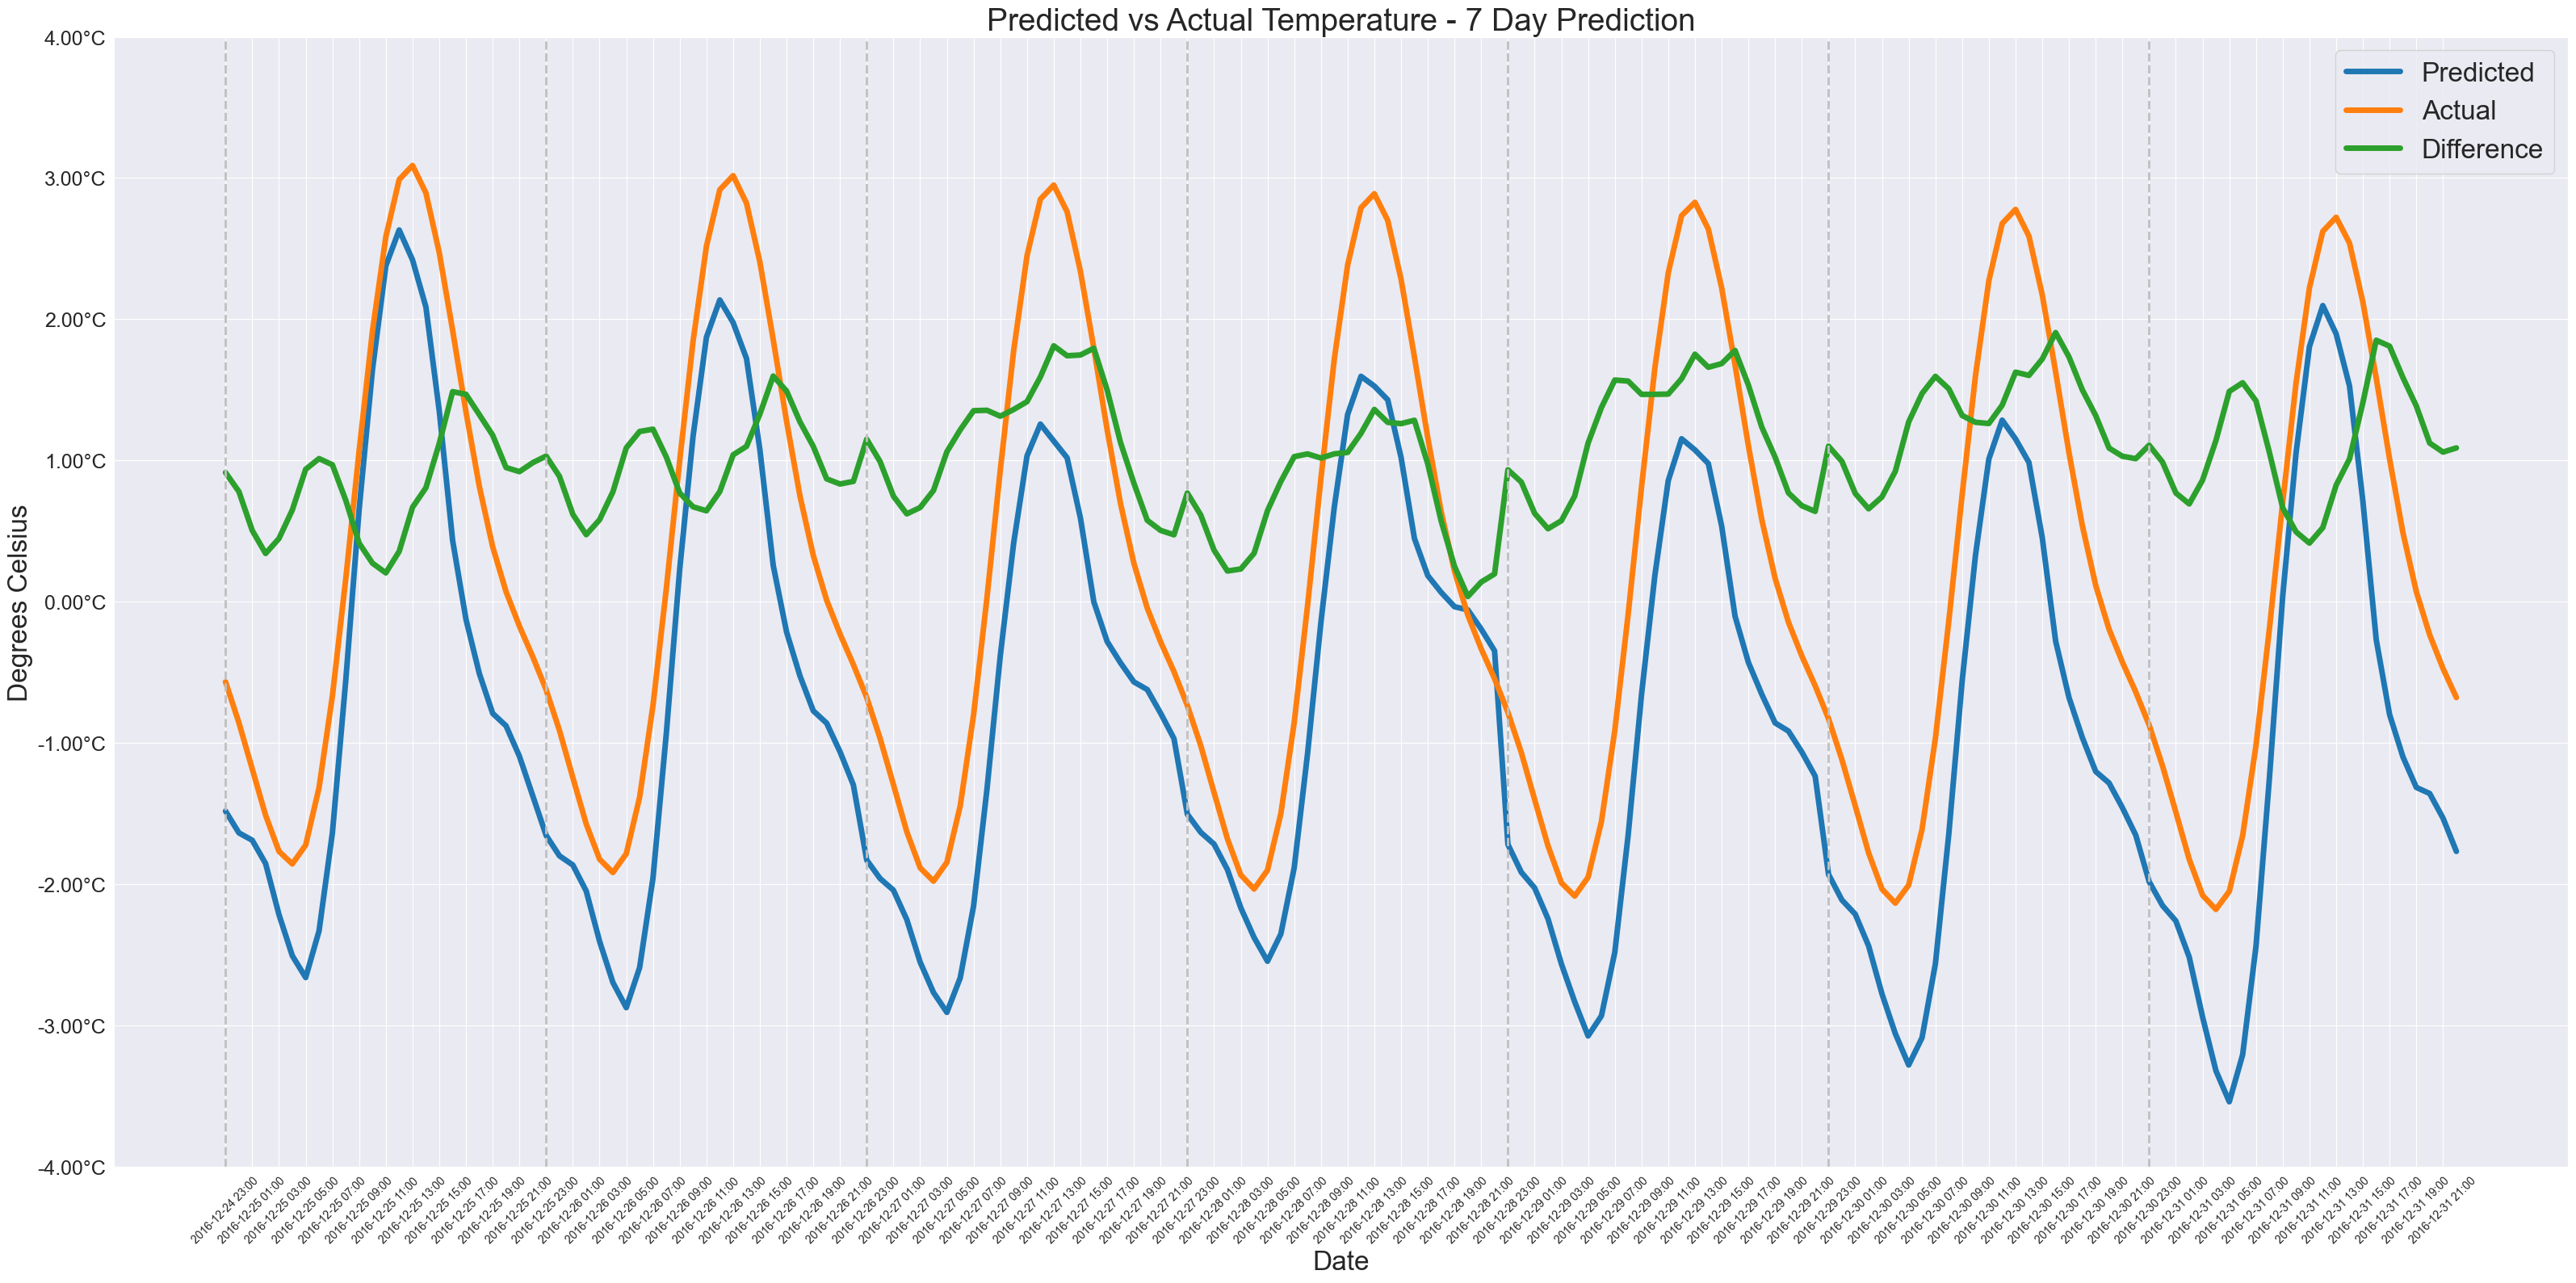

In [203]:
# Initialize lists to store all predictions and actual values
all_predictions = []
all_actual_values = []

# Loop skipping 7 days to get predictions every 24 hours
for day in range(-145, 0, 24):
    # Calculate the starting and ending indices for the slice
    start_index = day
    end_index = day + 1
    if end_index!= 0:
        # Extract the last 74 hours of the test data for the current day
        X_test_74_hours = X_test[start_index:end_index, :] 
        # Make predictions based on the last 3-day window
        predictions = best_model.predict(X_test_74_hours)
        # Append the predictions  to a lists
        all_predictions.extend(predictions.flatten())
        
        y_test_74_hours = y_test[start_index:end_index] 
        all_actual_values.extend(y_test_74_hours.flatten())
    else:
        X_test_74_hours = X_test[start_index:, :]
        # Make predictions based on the last 3-day window
        predictions = best_model.predict(X_test_74_hours)
        # Append the predictions and to a list
        all_predictions.extend(predictions.flatten())
        # Extract the last 74 hours of the test data for the last day
        y_test_74_hours = y_test[start_index:]
        all_actual_values.extend(y_test_74_hours.flatten())


date_time_7_days = weather.index[-24*7:].strftime('%Y-%m-%d %H:%M')

# Initialize a list to store rows of the table
table_data = []

difference_7_days = []
# Append a row to the table_data list containing date-time, predicted values, and actual values
for j in range(len(all_predictions)):
    difference_7_days.append(abs(all_actual_values[j] - all_predictions[j]))
    table_data.append([date_time_7_days[j], all_predictions[j], all_actual_values[j], difference_7_days[j]])

# Define column headers
headers = ['Date-Time', 'Predicted', 'Actual', 'Difference']

# Print the table using tabulate
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Plot predictions and actual values
sns.set_style("darkgrid")

plt.figure(figsize=(32, 16))
sns.lineplot(x=date_time_7_days, y=all_predictions, label='Predicted', linewidth=5)
sns.lineplot(x=date_time_7_days, y=all_actual_values, label='Actual', linewidth=5)
sns.lineplot(x=date_time_7_days, y=difference_7_days, label='Difference', linewidth=5)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Degrees Celsius', fontsize=24)
plt.title('Predicted vs Actual Temperature - 7 Day Prediction', fontsize=28)
plt.legend(fontsize=24)
plt.grid(True)
plt.yticks(plt.gca().get_yticks(), [f'{x:.2f}°C' for x in plt.gca().get_yticks()], fontsize=18)
plt.xticks(date_time_7_days[::2], rotation=45)

# Add vertical lines every 24 observations
for i in range(0, len(date_time_7_days), 24):
    plt.axvline(x=date_time_7_days[i], color='silver', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
